In [1]:
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import matplotlib.pyplot as plt  # Plotting using matplotlib
import numpy as np  # Numpy


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("Running on " + device)

Running on cuda


# Test for 1D - Method 1 (Not using torch.roll)

In [ ]:
def get_loss1d2(pred, original):
    # 0 at window[391] and 1 elsewhere
    window = torch.ones(784)
    window[391] = 0
    window = window.to(device)

    lw = 784

    # Creating toeplitz matrix A
    x = original.view(784).to(device)
    h = lw
    A = torch.zeros((2*h-1, h))
    for i in range(h):
        A[i:i+h, i] = x[:]
    A = A.to(device)
    A_T = torch.transpose(A, 0, 1)

    # Creating padded vector b
    b = pred.view(784).to(device)
    n = 2*lw-1-28*28
    l = np.floor(n/2)
    r = n-l
    #bz0 = torch.zeros(int(l)).to(device)
    #bz1 = torch.zeros(int(r)).to(device)
    b = nn.ConstantPad1d((int(l), int(r)), value=0)(b)
    #b = torch.cat([bz0, b, bz1], dim = 0).to(device)
    # Calculating filter w with length of lw
    inv = torch.inverse(A_T @ A)
    # inv = inv.to(device)
    w = inv @ A_T @ b
   
    # plot the filter and check whether it is a delta function
    w2 = w.cpu().detach().numpy()
    plt.plot(w2)
    plt.show()
    
    # plot the output image after the input Toeplitz matrix convolved with the filter
    res = A @ w
    res = res[int(l):int(l+784)].reshape((28,28)).cpu().numpy()
    plt.imshow(res)
    plt.show()

    # Calculating loss for pred[k]
    loss = 0.5 * torch.sum((window * w)**2) 
    
    return loss.to(device)

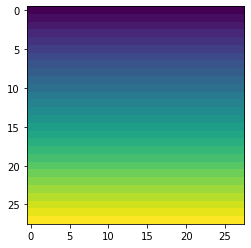

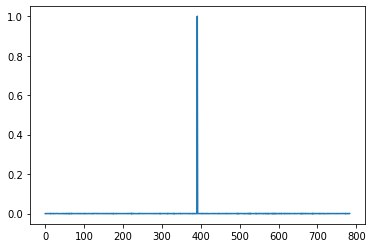

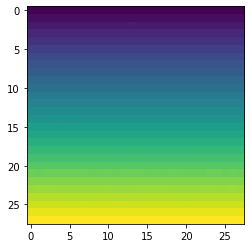

tensor(9.4055e-05, device='cuda:0')

In [ ]:
# set up a random image for test
P_test = torch.zeros(1, 1, 28, 28)
for i in range(P_test.size(2)):
   P_test[:, :, i, :] = i + 1

# plot this random image, which is considered as 
# the original image before the convolution operation
plt.imshow(P_test.squeeze(0).squeeze(0))
plt.show()

# check the filter
get_loss1d2(P_test.to(device), P_test.to(device))

### Use the same input and output data. The above test shows that filter w is a delta function. Also, the output image after the convolution between Toeplitz matrix and filter is still the same with the input image. So, filter is correct.

# Test for 1D - Method 2 (Using torch.roll) 


In [ ]:
def get_loss(pred, original):
    # 0 at window[391] and 1 elsewhere
    window = torch.ones(784)
    window[391] = 0
    window = window.to(device)

    lw = 784

    # Creating toeplitz matrix A
    x = torch.flatten(original, start_dim=1).squeeze()
    z = torch.zeros(lw-1).to(device)
    x = torch.cat([x, z], dim = 0).to(device)
    A_T = torch.zeros((lw, len(x))).to(device)
    for j in range(lw):
        A_T[j] = torch.roll(x, j)
    A = torch.transpose(A_T, 0, 1)
    # Creating padded vector b
    b = torch.flatten(pred, start_dim=1).squeeze()
    n = 2*lw-1-28*28
    l = np.floor(n/2)
    r = n-l
    bz0 = torch.zeros(int(l)).to(device)
    bz1 = torch.zeros(int(r)).to(device)
    b = torch.cat([bz0, b, bz1], dim = 0).to(device)
    # Calculating filter w with length of lw
    inv = torch.inverse(A_T @ A)
    # inv = inv.to(device)
    w = inv @ A_T @ b
    
    # plot and check wheter w is a delta function
    w2 = w.cpu().detach().numpy()
    plt.plot(w2)
    plt.show()

    # plot the output image after the input Toeplitz matrix convolved with the filter
    res = A @ w
    res = res[int(l):int(l+784)].reshape((28,28)).cpu().numpy()
    plt.imshow(res)
    plt.show()

    # Calculating loss for pred[k]
    loss = 0.5 * torch.sum((window * w)**2) 
    
    return loss.to(device)


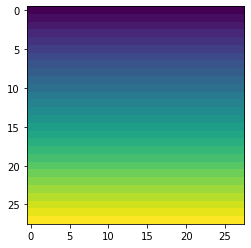

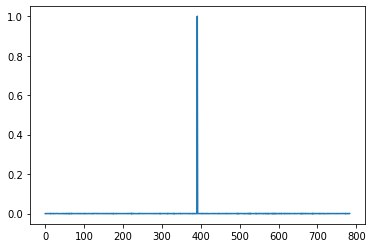

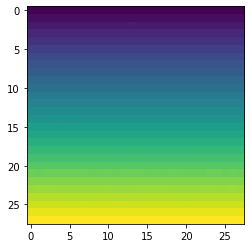

tensor(9.4055e-05, device='cuda:0')

In [ ]:
# set up a random image for test
P_test = torch.zeros(1, 1, 28, 28)
for i in range(P_test.size(2)):
   P_test[:, :, i, :] = i + 1

# plot this random image, which is considered as 
# the original image before the convolution operation
plt.imshow(P_test.squeeze(0).squeeze(0))
plt.show()

# check the filter
get_loss(P_test.to(device), P_test.to(device))


### Use the same input and output data. The above test shows that filter w is a delta function. Also, the output image after the convolution between Toeplitz matrix and filter is still the same with the input image. So, filter is correct.

# Test for 2D

In [ ]:
import torch
import numpy as np
# Generating Toeplitz matrix A

# x = torch.from_numpy(np.array([[1,2,3,4],[3,4,2,4],[1,2,3,4],[1,2,3,4]]))
x = torch.from_numpy(np.array([[1,2,3],[4,5,6],[7,8,9]]))
print('a:')
print(x)
print(' ')
# x = torch.from_numpy(np.array([[1,2],[3,4]]))
h = x.size(0)
C = torch.zeros((2*h-1, 2*h-1, h))
for i in range(h):
    toep = torch.zeros((h, 2*h-1))
    z = torch.zeros(2*h-1-h)
    a = torch.cat([x[i], z], dim = 0)
    for j in range(h):
        toep[j] = torch.roll(a, j)
    toep = torch.transpose(toep, 0, 1)
    C[i] = toep

A = C.reshape(((2*h-1)**2, h))

for j in range(1, h):
    A = torch.hstack((A, torch.roll(C, j, dims=-3).reshape(((2*h-1)**2), h)))
print('A:')
print(A)
print(' ')
A_T = torch.transpose(A, 0, 1)


# Creating padding for matrix b
#b = torch.from_numpy(np.array([[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[1,2,3,4,0,0,0],[3,4,2,4,0,0,0],[1,2,3,4,0,0,0],[1,2,3,4,0,0,0]])).float()
# b = torch.from_numpy(np.array([[0,0,0,0,0],[0,0,0,0,0],[1,2,3,0,0],[3,4,2,0,0],[1,2,3,0,0]])).float()
# b = torch.from_numpy(np.array([[0,0,0],[1,2,0],[3,4,0]])).float()

# top padding
tp = torch.zeros(int((2*h-1-h)/2), 2*h-1)
# bottom padding
bp = torch.zeros(2*h-1-h-int((2*h-1-h)/2), 2*h-1)
# right padding
rp = torch.zeros((h, int((2*h-1-h)/2)))
# left padding 
lp = torch.zeros((h, 2*h-1-h-int((2*h-1-h)/2)))
# Stacking padding
b = torch.hstack((lp, x, rp))
b = torch.vstack((tp, b, bp))

print('b:')
print(b)
print(' ')
b = b.view((2*h-1)**2)
inv = torch.inverse(A_T @ A)
# inv = inv.to(device)
w = inv @ A_T @ b
print('w:')
print(w)
print(' ')

print('Padded A*w = b :')
print((A @ w).reshape(2*h-1,2*h-1))

    

a:
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
 
A:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 1., 0., 0., 0., 0., 0., 0., 0.],
        [3., 2., 1., 0., 0., 0., 0., 0., 0.],
        [0., 3., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 3., 0., 0., 0., 0., 0., 0.],
        [4., 0., 0., 1., 0., 0., 0., 0., 0.],
        [5., 4., 0., 2., 1., 0., 0., 0., 0.],
        [6., 5., 4., 3., 2., 1., 0., 0., 0.],
        [0., 6., 5., 0., 3., 2., 0., 0., 0.],
        [0., 0., 6., 0., 0., 3., 0., 0., 0.],
        [7., 0., 0., 4., 0., 0., 1., 0., 0.],
        [8., 7., 0., 5., 4., 0., 2., 1., 0.],
        [9., 8., 7., 6., 5., 4., 3., 2., 1.],
        [0., 9., 8., 0., 6., 5., 0., 3., 2.],
        [0., 0., 9., 0., 0., 6., 0., 0., 3.],
        [0., 0., 0., 7., 0., 0., 4., 0., 0.],
        [0., 0., 0., 8., 7., 0., 5., 4., 0.],
        [0., 0., 0., 9., 8., 7., 6., 5., 4.],
        [0., 0., 0., 0., 9., 8., 0., 6., 5.],
        [0., 0., 0., 0., 0., 9., 0., 0., 6.],
        [0., 0

### From above printouts, it shows that A is in a correct form of a Toeplitz matrix of a. b is also padded in a correct way. It shows that the 2D convolution is correct since A*w = b. 

In [24]:
def get_loss2d(pred, original):
    h = 28
    window = torch.ones(h*h)
    window[378] = 0
    window = window.to(device)

    # Creating toeplitz matrix A
    x = original.squeeze().to(device)
    C = torch.zeros((2*h-1, 2*h-1, h)).to(device)
    for i in range(h):
        toep = torch.zeros((h, 2*h-1)).to(device)
        z = torch.zeros(2*h-1-h).to(device)
        a = torch.cat([x[i], z], dim = 0)
        for j in range(h):
            toep[j] = torch.roll(a, j)
        toep = torch.transpose(toep, 0, 1)
        C[i] = toep

    A = C.reshape(((2*h-1)**2, h))
    for j in range(1, h):
        A = torch.hstack((A, torch.roll(C, j, dims=-3).reshape(((2*h-1)**2), h)))
    A_T = torch.transpose(A, 0, 1).to(device)

    # Creating padded vector b

    # top padding
    tp = torch.zeros(int((2*h-1-h)/2), 2*h-1).to(device)
    # bottom padding
    bp = torch.zeros(2*h-1-h-int((2*h-1-h)/2), 2*h-1).to(device)
    # right padding
    rp = torch.zeros((h, int((2*h-1-h)/2))).to(device)
    # left padding 
    lp = torch.zeros((h, 2*h-1-h-int((2*h-1-h)/2))).to(device)
    # Stacking padding
    b = torch.hstack((lp, pred.squeeze().to(device), rp))
    b = torch.vstack((tp, b, bp))

    b = b.view((2*h-1)**2)

    inv = torch.inverse(A_T @ A)

    w = inv @ A_T @ b

    # plot the output image after the input Toeplitz matrix convolved with the filter
    res = A @ w
    res = res.reshape((2*h-1, 2*h-1)).cpu().numpy()
    res2 = res[int((2*h-1-h)/2):(int((2*h-1-h)/2)+h),(2*h-1-h-int((2*h-1-h)/2)):(2*h-1-int((2*h-1-h)/2))]
    plt.imshow(res2)
    plt.show()

    w2 = w.cpu().detach().numpy()
    plt.plot(w2)
    plt.show()

    loss = 0.5 * torch.sum((window * w)**2)
    
    return loss.to(device)

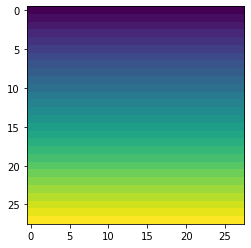

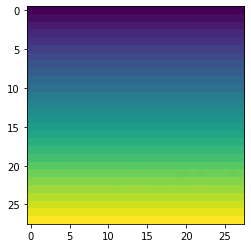

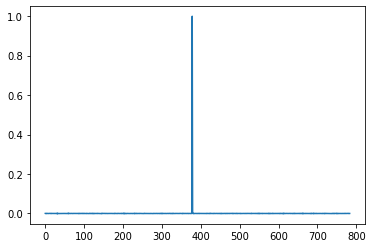

tensor(5.3352e-05, device='cuda:0')

In [25]:
# set up a random image for test
P_test = torch.zeros(1, 1, 28, 28)
for i in range(P_test.size(2)):
   P_test[:, :, i, :] = i + 1


# plot this random image, which is considered as 
# the original image before the convolution operation
plt.imshow(P_test.squeeze(0).squeeze(0))
plt.show()

# check the filter
get_loss2d(P_test.to(device), P_test.to(device))

### Use the same input and output data. The above test shows that filter w is a delta function. Also, the output image after the convolution between Toeplitz matrix and filter is still the same with the input image. So, filter is correct when the calculation is 2D.